# Download data and unzip

In [0]:
!wget --content-disposition 'https://docs.google.com/uc?export=download&id=1-mpuwj2H45sHGRa-N1PQ8qeBSzmM1ubx' 
!apt-get install unzip
!unzip 'competitive-data-science-predict-future-sales.zip' -d data

!gunzip 'data/test.csv.gz'
!gunzip 'data/sample_submission.csv.gz'
!gunzip 'data/sales_train.csv.gz'

KeyboardInterrupt: ignored

In [0]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
import time
import numpy as np
import math
import pandas as pd
from datetime import datetime
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import random
import datetime

In [0]:
# items = pd.read_csv('data/items.csv')
# shops = pd.read_csv('data/shops.csv')
# cats = pd.read_csv('data/item_categories.csv')
train = pd.read_csv('data/sales_train.csv', parse_dates=['date'], infer_datetime_format=True, dayfirst=True)

test  = pd.read_csv('data/test.csv').set_index('ID')

In [0]:
print ('number of shops: ', train['shop_id'].max())

num_items = train['item_id'].max()
print ('number of items: ', num_items)
num_month = train['date_block_num'].max()
print ('number of month: ', num_month)
print ('size of train: ', train.shape)
train[:10]

number of shops:  59
number of items:  22169
number of month:  33
size of train:  (2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0
6,2013-01-02,0,25,2565,549.00,1.0
7,2013-01-04,0,25,2572,239.00,1.0
8,2013-01-11,0,25,2572,299.00,1.0
9,2013-01-03,0,25,2573,299.00,3.0


In [0]:
train_num = train.groupby(['date_block_num']).sum().reset_index()
train_num[:5]

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,3417068,1183971787,8.221187e+07,131479.0
1,1,3111582,1076043980,7.558019e+07,128090.0
2,2,4016457,1220911622,8.429831e+07,147142.0
3,3,3164978,971345965,6.151282e+07,107190.0
4,4,3093999,950372988,5.727413e+07,106970.0


In [0]:
train_num = train_num.drop(labels=['shop_id', 'item_id','item_price'], axis=1)
train_num[:5]

,date_block_num,item_cnt_day
0,0,131479.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0


In [0]:
t = np.array(train_num).astype('float')
print(t)

[[0.00000e+00 1.31479e+05]
 [1.00000e+00 1.28090e+05]
 [2.00000e+00 1.47142e+05]
 [3.00000e+00 1.07190e+05]
 [4.00000e+00 1.06970e+05]
 [5.00000e+00 1.25381e+05]
 [6.00000e+00 1.16966e+05]
 [7.00000e+00 1.25291e+05]
 [8.00000e+00 1.33332e+05]
 [9.00000e+00 1.27541e+05]
 [1.00000e+01 1.30009e+05]
 [1.10000e+01 1.83342e+05]
 [1.20000e+01 1.16899e+05]
 [1.30000e+01 1.09687e+05]
 [1.40000e+01 1.15297e+05]
 [1.50000e+01 9.65560e+04]
 [1.60000e+01 9.77900e+04]
 [1.70000e+01 9.74290e+04]
 [1.80000e+01 9.12800e+04]
 [1.90000e+01 1.02721e+05]
 [2.00000e+01 9.92080e+04]
 [2.10000e+01 1.07422e+05]
 [2.20000e+01 1.17845e+05]
 [2.30000e+01 1.68755e+05]
 [2.40000e+01 1.10971e+05]
 [2.50000e+01 8.41980e+04]
 [2.60000e+01 8.20140e+04]
 [2.70000e+01 7.78270e+04]
 [2.80000e+01 7.22950e+04]
 [2.90000e+01 6.41140e+04]
 [3.00000e+01 6.31870e+04]
 [3.10000e+01 6.60790e+04]
 [3.20000e+01 7.28430e+04]
 [3.30000e+01 7.10560e+04]]


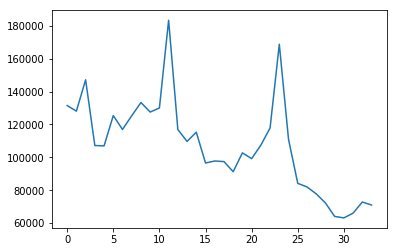

In [0]:
# print(t[:,1])
t = t[:,1]
plt.plot(t)
plt.show()

In [0]:
def max_min_normalization(x):
    return np.array([(float(i)-min(x))/float(max(x)-min(x)) for i in x])
  
def de_normalization(original,x):
    return float(x)*(float(max(original)-min(original)))+min(original)

[0.56836586 0.54016063 0.69872248 0.36621863 0.36438767 0.51761475
 0.44758021 0.51686572 0.58378761 0.53559153 0.55613166 1.
 0.4470226  0.38700012 0.43368982 0.27771628 0.28798635 0.2849819
 0.23380633 0.32902501 0.29978777 0.36814947 0.45489576 0.87859848
 0.39768632 0.1748658  0.15668928 0.12184262 0.07580209 0.00771503
 0.         0.02406891 0.08036286 0.06549041]


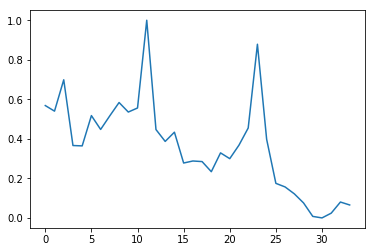

In [0]:
from sklearn import preprocessing

T = t

t = max_min_normalization(t)

print(t)

plt.plot(t)
plt.show()

In [0]:
def create_dataset(dataset,on,look_back=2):
    dataX, dataY=[], []
    for i in range(len(dataset)-look_back):
        a=dataset[i:(i+look_back)]
        dataX.append(a)
        
        #dataX.append()
        dataY.append(dataset[i+look_back])
    return np.array(dataX), np.array(dataY)

In [0]:
train_X1 ,train_Y1 = create_dataset(t.reshape(len(t),1),2)
print(train_X1[:5])
print(train_Y1[:5])

[[[0.56836586]
  [0.54016063]]

 [[0.54016063]
  [0.69872248]]

 [[0.69872248]
  [0.36621863]]

 [[0.36621863]
  [0.36438767]]

 [[0.36438767]
  [0.51761475]]]
[[0.69872248]
 [0.36621863]
 [0.36438767]
 [0.51761475]
 [0.44758021]]


In [0]:
train_x1 = train_X1.reshape(-1,1,2)
train_y1 = train_Y1.reshape(-1,1,1)

train_x1 = Variable(torch.from_numpy(train_x1)).float()
train_y1 = Variable(torch.from_numpy(train_y1)).float()

In [0]:
class lstm_reg(torch.nn.Module):
  
  def __init__(self,input_size,hidden_size, output_size=1,num_layers=2):
    super(lstm_reg,self).__init__()

    self.rnn = torch.nn.LSTM(input_size,hidden_size,num_layers)
    self.reg = torch.nn.Linear(hidden_size,output_size)

  def forward(self,x):
    x, _ = self.rnn(x)
    s,b,h = x.shape
    x = x.view(s*b, h)
    x = self.reg(x)
    x = x.view(s,b,-1)
    return x

In [0]:
net1 = lstm_reg(2,8).cuda()
criterion = torch.nn.MSELoss()
optimizer1 = torch.optim.Adam(net1.parameters(),lr=1.5e-2)

In [0]:
EPOCH = 10000

In [0]:
for e in range(EPOCH):
  var_x1 = Variable(train_x1).cuda()
  var_y1 = Variable(train_y1).cuda()

  out = net1(var_x1)
  loss = criterion(out, var_y1)

  optimizer1.zero_grad()
  loss.backward()
  optimizer1.step()
  if (e+1)%500 == 0:
      print('Epoch: {}, Loss:{:.8f}'.format(e+1, loss.data.cpu()))

Epoch: 500, Loss:0.00066892
Epoch: 1000, Loss:0.00006689
Epoch: 1500, Loss:0.00000088
Epoch: 2000, Loss:0.00000001
Epoch: 2500, Loss:0.00001186
Epoch: 3000, Loss:0.01886929
Epoch: 3500, Loss:0.00089942
Epoch: 4000, Loss:0.00002662
Epoch: 4500, Loss:0.00000166
Epoch: 5000, Loss:0.00000853
Epoch: 5500, Loss:0.00000047
Epoch: 6000, Loss:0.00000018
Epoch: 6500, Loss:0.00000007
Epoch: 7000, Loss:0.00000067
Epoch: 7500, Loss:0.00000002
Epoch: 8000, Loss:0.00000010
Epoch: 8500, Loss:0.00011248
Epoch: 9000, Loss:0.00000001
Epoch: 9500, Loss:0.00000001
Epoch: 10000, Loss:0.00002789


In [0]:
p1 = net1(Variable(train_x1).cuda())
p1 = p1.view(-1).data.cpu().numpy()

In [0]:
def appendPrediction(NET,Data,week):#7 week
  for i in range(week):
    length  = len(Data)
    pre_in = np.array([[Data[length-2],Data[length-1]]])
    #print(length)
    
    pre_in = torch.unsqueeze(torch.from_numpy(pre_in), dim=1).float().cuda()
    #print(pre_in)
    peak_add = NET(pre_in).view(-1).data.cpu().numpy()[0]
    #print(peak_add)
    Data = np.append(Data,peak_add)
    
  return Data

In [0]:
p1 = appendPrediction(net1,p1,1)

Text(0.5, 1.0, 'predict')

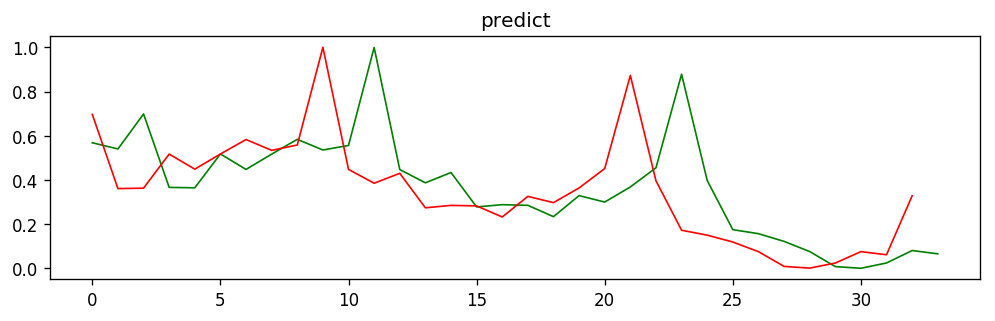

In [0]:
fig = plt.figure(figsize=(10,22),dpi=120)
ax1 = fig.add_subplot(7,1,1)

ax1.plot(t, lw=1, c='g', label='real')
ax1.plot(p1, lw=1, c='r', label='prediction')
ax1.set_title('predict')

In [0]:
print(de_normalization(T,p1[len(p1)-2]))

70550.23951259255


In [0]:
t_result = de_normalization(T,p1[len(p1)-1])
print('The total sale at 2015-11 : '+ format(t_result) )

The total sale at 2015-11 : 102615.89955744147


In [0]:
def creatFullarray(length,data,is_average=False):
  #print(length)
  a = np.arange(length)
  a = np.append([a],[np.zeros(length)],axis=0)
  a = np.transpose(a)
  ind = 0
  for n in range(length-1):
    if n == data[ind,0]:
      #print('get n : '+format(n))
      a[n,1] = data[ind,1]
      if ind<(len(data)-1):
        ind = ind + 1
        #print(ind)
  if is_average:
    a1 = a[:,0]
    a2 = a[:,1]
    #print(a2)
    #a2 = np.array([(float(i)-np.min(a2))/float(np.max(a2)-np.min(a2)) for i in a2])
    a2 = a2*(1/np.sum(a2))
    a = np.append([a1],[a2],axis=0)
    a = np.transpose(a)
  return a

In [0]:
train_per = train.groupby(['date_block_num','item_id']).sum().reset_index()
train_per = train_per.drop(labels=['shop_id','item_price'], axis=1)

In [0]:
a = []
for n in range(num_month):
  #print(n)
  s = train_per.loc[train_per['date_block_num'] == n]
  s = s.drop(labels=['date_block_num'], axis=1)
  s = np.array(s)
  
  s = creatFullarray(num_items,s,is_average=False)
  
  s = s[:,1]
  a.append(s)
print(np.array(a))

# print(len(a))

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  8. 34.  0.]
 [ 0.  0.  0. ... 11. 29.  0.]
 [ 0.  0.  0. ...  5. 21.  0.]]


In [0]:
train_X2 ,train_Y2 = create_dataset(np.array(a),2)
print(train_X2[:5])
print(train_Y2[:5])

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
class MyDataset(Dataset):
  def __init__(self, qua, ans):
    self.Q = qua
    self.A = ans

  def __len__(self):
    return len(self.A)

  def __getitem__(self, idx):
      q = self.Q[idx]
      a = self.A[idx]
      return q,a

In [0]:
train_x2 = train_X2.reshape(-1,1,2)
train_y2 = train_Y2.reshape(-1,1,1)

In [0]:
train_dataloader = DataLoader(MyDataset(train_x2,train_y2),batch_size=500, shuffle=True)

In [0]:
net2 = lstm_reg(2,2000,output_size=num_items).cuda()

In [0]:
for e in range(EPOCH):
  for step, (x, y) in enumerate(train_dataloader):
    var_x1 = x.type(torch.cuda.FloatTensor)
    var_y1 = y.type(torch.cuda.FloatTensor)

    out = net2(var_x1)
    loss = criterion(out, var_y1)

    optimizer1.zero_grad()
    loss.backward()
    optimizer1.step()
    if (step)%50 == 0:
        #print('Epoch: {}, Loss:{:.5f}'.format(e+1, loss.data.cpu()))
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(e, 
         step * len(var_x1), len(train_dataloader.dataset),100. * step / len(train_dataloader), loss.data.item()))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([500, 1, 1])) that is different to the input size (torch.Size([500, 1, 22169])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Epoch: 0 [0/687239 (0%)]	Loss: 187.926804
Train Epoch: 0 [25000/687239 (4%)]	Loss: 715.876953
Train Epoch: 0 [50000/687239 (7%)]	Loss: 688.730896
Train Epoch: 0 [75000/687239 (11%)]	Loss: 216.964996
Train Epoch: 0 [100000/687239 (15%)]	Loss: 196.420715
Train Epoch: 0 [125000/687239 (18%)]	Loss: 334.076874
Train Epoch: 0 [150000/687239 (22%)]	Loss: 2040.141479
Train Epoch: 0 [175000/687239 (25%)]	Loss: 149.468658
Train Epoch: 0 [200000/687239 (29%)]	Loss: 465.479004
Train Epoch: 0 [225000/687239 (33%)]	Loss: 374.068756
Train Epoch: 0 [250000/687239 (36%)]	Loss: 266.830841
Train Epoch: 0 [275000/687239 (40%)]	Loss: 791.155273
Train Epoch: 0 [300000/687239 (44%)]	Loss: 505.397003
Train Epoch: 0 [325000/687239 (47%)]	Loss: 237.756821
Train Epoch: 0 [350000/687239 (51%)]	Loss: 597.450928
Train Epoch: 0 [375000/687239 (55%)]	Loss: 2084.762939
Train Epoch: 0 [400000/687239 (58%)]	Loss: 327.152954
Train Epoch: 0 [425000/687239 (62%)]	Loss: 1897.011475
Train Epoch: 0 [450000/687239 (65%)]

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([239, 1, 1])) that is different to the input size (torch.Size([239, 1, 22169])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Epoch: 1 [0/687239 (0%)]	Loss: 157.128799
Train Epoch: 1 [25000/687239 (4%)]	Loss: 270.222839
Train Epoch: 1 [50000/687239 (7%)]	Loss: 659.519165
Train Epoch: 1 [75000/687239 (11%)]	Loss: 123.890747
Train Epoch: 1 [100000/687239 (15%)]	Loss: 3219.133057
Train Epoch: 1 [125000/687239 (18%)]	Loss: 1249.129395
Train Epoch: 1 [150000/687239 (22%)]	Loss: 406.990875
Train Epoch: 1 [175000/687239 (25%)]	Loss: 267.224823
Train Epoch: 1 [200000/687239 (29%)]	Loss: 1260.717041
Train Epoch: 1 [225000/687239 (33%)]	Loss: 294.186768
Train Epoch: 1 [250000/687239 (36%)]	Loss: 504.493011
Train Epoch: 1 [275000/687239 (40%)]	Loss: 618.508911
Train Epoch: 1 [300000/687239 (44%)]	Loss: 21709.539062
Train Epoch: 1 [325000/687239 (47%)]	Loss: 130.968658
Train Epoch: 1 [350000/687239 (51%)]	Loss: 250.684677
Train Epoch: 1 [375000/687239 (55%)]	Loss: 5092.083496
Train Epoch: 1 [400000/687239 (58%)]	Loss: 1929.057129
Train Epoch: 1 [425000/687239 (62%)]	Loss: 1997.593262
Train Epoch: 1 [450000/687239 (

In [0]:
a = np.array([])

a = np.append(a,[1,2,3,4], axis=0)
print(a)

a = np.append(a,[1,2,3,4], axis=0)
print(a)